In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt

In [3]:
import subprocess
import json

In [4]:



file_path = '../Resource/neo_data.json'  # Relative to current working directory

# Read the JSON
with open(file_path, 'r') as file:
    data = json.load(file)


# Flatten the JSON data
df = pd.DataFrame(data)
df.head()

,id,name,absolute_magnitude_h,estimated_diameter_km_min,estimated_diameter_km_max,is_potentially_hazardous,close_approach_date,relative_velocity_kph,miss_distance_km,orbiting_body
0,3564720,(2011 HS60),21.29,0.146742,0.328125,False,2020-01-01,63987.979663269,29751747.345304547,Earth
1,3591759,(2011 YE40),25.20,0.024241,0.054205,False,2020-01-01,46009.0330705321,9249996.309374155,Earth
2,3630817,(2013 EC20),29.00,0.004213,0.009420,False,2020-01-01,10057.3249552683,24237651.402903484,Earth
3,3747497,(2016 EF195),25.50,0.021113,0.047211,False,2020-01-01,63174.4052794664,41337820.22026194,Earth
4,3893737,(2019 WE5),23.30,0.058151,0.130029,False,2020-01-01,18010.1706796564,20135488.775634952,Earth


In [5]:
# Convert data types
df['relative_velocity_kph'] = pd.to_numeric(df['relative_velocity_kph'], errors='coerce')
df['miss_distance_km'] = pd.to_numeric(df['miss_distance_km'], errors='coerce')
df.dtypes

id                            object
name                          object
absolute_magnitude_h         float64
estimated_diameter_km_min    float64
estimated_diameter_km_max    float64
is_potentially_hazardous        bool
close_approach_date           object
relative_velocity_kph        float64
miss_distance_km             float64
orbiting_body                 object
dtype: object

In [6]:

#Simulate Earth-relative lat/lon (mock  data for testing)

np.random.seed(42)
df['latitude'] = np.random.uniform(-90, 90, size=len(df))
df['longitude'] = np.random.uniform(-180, 180, size=len(df))

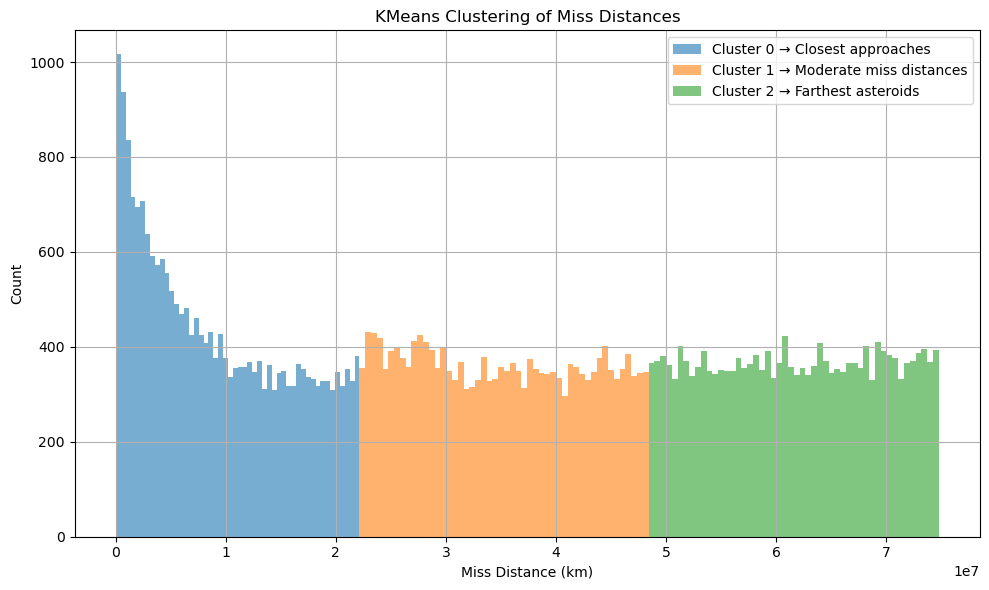

In [7]:
X=df[['miss_distance_km']]
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
# Add cluster labels to the DataFrame
df['miss_cluster'] = kmeans.fit_predict(X)

# Sort clusters by average distance (optional for clarity)
cluster_means = df.groupby('miss_cluster')['miss_distance_km'].mean().sort_values()
cluster_map = {old: new for new, old in enumerate(cluster_means.index)}
df['miss_cluster'] = df['miss_cluster'].map(cluster_map)

# Plot
plt.figure(figsize=(10, 6))
for cluster in sorted(df['miss_cluster'].unique()):
    subset = df[df['miss_cluster'] == cluster]
    plt.hist(subset['miss_distance_km'], bins=50, alpha=0.6, label=f'Cluster {cluster}')

# Custom legend labels
labels = [
    "Cluster 0 → Closest approaches",
    "Cluster 1 → Moderate miss distances",
    "Cluster 2 → Farthest asteroids"
]


plt.xlabel("Miss Distance (km)")
plt.ylabel("Count")
plt.title("KMeans Clustering of Miss Distances")
plt.legend(labels, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()




In [25]:
from folium.plugins import MarkerCluster

#Ensure the date column is in datetime format
df['close_approach_date'] = pd.to_datetime(df['close_approach_date'])
df['is_potentially_hazardous'] = df['is_potentially_hazardous'].astype(int)

# Filter for hazardous NEOs in 2025 only
filtered_df = df[
    (df['is_potentially_hazardous'] == 1) & 
    (df['close_approach_date'].dt.year == 2025) &
    (df['miss_distance_km'] < 5000000)  # Filter for close approaches
]


#Plot heatmap
m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB dark_matter')



# Add a marker for each NEO 

for index, row in filtered_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Name: {row['name']}\nDate: {row['close_approach_date'].date()}\nHazardous: {row['is_potentially_hazardous']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Prepare heatmap data
heat_data = [[row['latitude'], row['longitude']] for index, row in filtered_df.iterrows()]

# Add heatmap
HeatMap(heat_data, radius=20, blur=15, max_zoom=0.5).add_to(m)

In [26]:
# Save map
m.save("neo_impact_heatmap.html")
print("✅ Heatmap saved as neo_impact_heatmap.html")

✅ Heatmap saved as neo_impact_heatmap.html
